# CS6340 Project 2: Predict Real Estate Sale Prices

## By Jack Schlederer

TODO

In [124]:
import dateutil.parser
import numpy
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN, KMeans

from math import sqrt

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading the data

Let's start by loading in the Sacramento real estate transaction dataset.

In [125]:
housing_df = pd.read_csv(os.path.join(os.getcwd(), 'Sacramentorealestatetransactions.csv'))
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [126]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


## Massaging the data

Let's set some of the fields we know to be categorical as Pandas type `category`.

In [127]:
housing_df['city'] = housing_df['city'].astype('category')
housing_df['zip'] = housing_df['zip'].astype('category')
housing_df['state'] = housing_df['state'].astype('category')
housing_df['type'] = housing_df['type'].astype('category')
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   street     985 non-null    object  
 1   city       985 non-null    category
 2   zip        985 non-null    category
 3   state      985 non-null    category
 4   beds       985 non-null    int64   
 5   baths      985 non-null    int64   
 6   sq__ft     985 non-null    int64   
 7   type       985 non-null    category
 8   sale_date  985 non-null    object  
 9   price      985 non-null    int64   
 10  latitude   985 non-null    float64 
 11  longitude  985 non-null    float64 
dtypes: category(4), float64(2), int64(4), object(2)
memory usage: 69.8+ KB


Further massaging the data for better usage in a ML model, let's one-hot encode the city, ZIP code, and property type using the `get_dummies` method.

In [128]:
one_hot_df_list = list()

for column in ['city', 'zip', 'type']:
  _oh_encoded = pd.get_dummies(housing_df[column], prefix=column)
  one_hot_df_list.append(_oh_encoded)

experiment_dataframe = pd.concat(one_hot_df_list, axis=1)
housing_df = pd.concat([housing_df, experiment_dataframe], axis=1)

## "Binning" transaction prices

To allow us to train-test split in a _stratified_ manner, we'll separate the transactions by price into a small number of ranges (bins). This way, we can split the training set and the testing set proportionally to each bin.

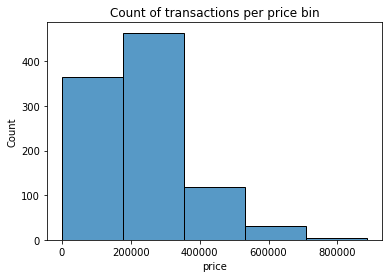

In [129]:
bin_count = 5

bins = numpy.histogram_bin_edges(housing_df['price'], bins=bin_count)
sns.histplot(housing_df['price'], bins=bins)

plt.title('Count of transactions per price bin')
plt.show()

We can just add the price bin number to the "master" dataframe we've been working with.

In [130]:
bin_array = numpy.digitize(housing_df['price'], bins)
housing_df['price_bin'] = bin_array
housing_df

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,price_bin
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
981,6932 RUSK

## Train-test splitting

Now that we have something to stratify by, let's use scikit-learn's train-test split function to split out 25% of our data for testing. The other 75% will be used to train the ML models.

In [131]:
housing_df['price_bin'] = housing_df['price_bin'].where(housing_df['price_bin'] != (bin_count + 1), other=bin_count)
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_bin'], random_state=42896)

Verifying size of each...

In [132]:
training_df.shape

(738, 124)

In [133]:
testing_df.shape

(247, 124)

Looks good!

## Preparing the data for ML models

Most machine learning models perform better when features with floating-point or integer values are "scaled" such that their mean is 0. This helps bring all the numeric features onto the same playing field, so no small number of features dominates the calculative structure at the core of the model, whether that's a regression function, a decision tree, or otherwise.

Here, we'll use a pipeline and scikit-learn's (henceforth referred to as sklearn per it's Python `import` statement) `StandardScaler` to scale the numeric features.

The categorical features are already one-hot encoded, but we could have also created a pipeline to perform that operation with sklearn functions, then combine the pipelines into _another_ pipeline for concision.

In [134]:
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

# We could make a pipeline here with a one-hot encoder for the categorical columns but that's already been done

# Fit and apply the StandardScaler with the training data, then apply it to the testing data
training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

# Get the price columns
training_prices = training_df['price']
testing_prices = testing_df['price']

# Drop the columns we don't want to use in the regression model
columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

Let's take a quick look at the now preprocessed data which will be fed into the predictor pipeline.

In [135]:
testing_df.head()

,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,beds_scaled,baths_scaled,sq__ft_scaled,latitude_scaled,longitude_scaled
264,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.808358,1.36610,0.527702,0.772513,-0.013592
612,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.721304,-0.88682,-0.547897,-0.595413,-0.522888
433,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.043527,0.23964,0.515843,1.045672,0.320557
160,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.721304,-0.88682,-0.572801,-1.401975,-0.118632
439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.808358,0.23964,0.275108,-2.266211,0.393881


## Predicting the prices

We'll use an `SGDRegressor` class from sklearn to predict the prices for our testing dataset. But first, we need to _train_ it with the training dataset.

In [136]:
reg = SGDRegressor()
reg.fit(training_df, training_prices)

SGDRegressor()

Easy, right? Now comes the fun part: predicting the prices. We'll construct a new dataframe with the actual prices and the predicted prices spit out by the trained SGDRegressor.

In [137]:
testing_prices_actual_predict = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': reg.predict(testing_df)})
testing_prices_actual_predict.head()

,actual_price,predicted_price
264,265000,267086.286851
612,75000,133461.480243
433,217500,334858.058874
160,71000,114012.585461
439,225500,252690.957928


These seem to be _somewhat_ in the ballpark (don't yell at me if there are outliers in the `head`, we'll take care of them later), so let's find the mean error.

In [138]:
actual_prices = testing_prices_actual_predict['actual_price']
predicted_prices = testing_prices_actual_predict['predicted_price']
error_pass_1 = sqrt(mean_squared_error(actual_prices, predicted_prices))
error_pass_1

105723.74833145613

This means that the average prediction is off by about $100k. Let's visualize the results. On the X-axis is the actual price of the transactions, with the predictions on the Y-axis. I've gone ahead and added a `Y=X` line too in red for reference. The closer our datapoints are to that, the more accurate the model is.

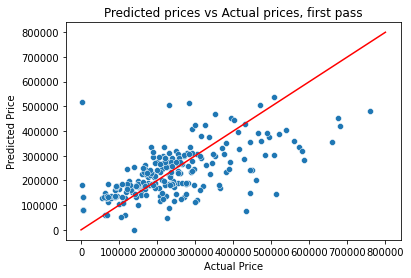

In [139]:
sns.scatterplot(x=actual_prices, y=predicted_prices)

X_plot = numpy.linspace(0, 8e5, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted prices vs Actual prices, first pass")
plt.show()

An alternative way to represent this is to plot the error as a function of the price predictions. I've also added a `Y=0` line in red for reference. Similarly, the closer the data points are to it, the more accurate the model is. Since the error used here is _signed_, transactions below the line had their price _over_ predicted, while the ones above it had their price _under_ predicted.

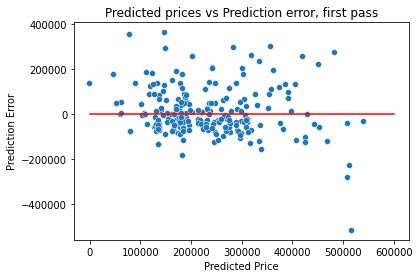

In [140]:
testing_prices_actual_predict['error'] = testing_prices_actual_predict['actual_price'] - testing_prices_actual_predict['predicted_price']

prediction_errors = testing_prices_actual_predict['error']

sns.scatterplot(x=predicted_prices, y=prediction_errors)

X_plot = numpy.linspace(0, 6e5, 10)
Y_plot = X_plot * 0
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")
plt.title("Predicted prices vs Prediction error, first pass")
plt.show()

## Removing Outliers

Let's remove the outliers that meet one or more of these conditions:
* Square-footage of 0
* Property type of "Unkown" [sic]
* Properties with very high or low prices

Removing the outliers is a good and cheap way to improve the accuracy of the model.

In [141]:
# Square-footage of 0
housing_df = housing_df[housing_df.sq__ft != 0]

# Property type of "Unkown"
housing_df = housing_df[housing_df.type != "Unkown"]

# Remove "very high" prices. Let's remove anything higher than the 99th price percentile
housing_df = housing_df[housing_df.price < housing_df['price'].quantile(.99)]

# Remove "very low" prices. Let's remove anything lower than the 1st price percentile
housing_df = housing_df[housing_df.price > housing_df['price'].quantile(.01)]

Let's take a look at the size of the new dataframe.

In [142]:
housing_df.shape

(796, 124)

Looks good! Now with the outliers removed, we'll have to redo our expiermental setup. That is, we'll have to re-bin, re-train-test split, re-preprocess, re-train the model, and re-predict. For the sake of brevity, since it's mostly copy-pasted from above, I'm going to do this all in a single cell with little annotation.

In [143]:
bin_count = 5

bins = numpy.histogram_bin_edges(housing_df['price'], bins=bin_count)

bin_array = numpy.digitize(housing_df['price'], bins)
housing_df['price_bin'] = bin_array

housing_df['price_bin'] = housing_df['price_bin'].where(housing_df['price_bin'] != (bin_count + 1), other=bin_count)
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_bin'], random_state=42896)

numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

training_prices = training_df['price']
testing_prices = testing_df['price']

columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

reg = SGDRegressor()
reg.fit(training_df, training_prices)

testing_prices_actual_predict = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': reg.predict(testing_df)})
testing_prices_actual_predict.head()

,actual_price,predicted_price
4,81900,100600.468998
209,168000,182994.887137
127,344250,431789.928529
175,111000,162489.701975
112,292024,268703.381341


Great! Let's recalculate our error now.

In [144]:
actual_prices = testing_prices_actual_predict['actual_price']
predicted_prices = testing_prices_actual_predict['predicted_price']
error_pass_2 = sqrt(mean_squared_error(actual_prices, predicted_prices))
error_pass_2

66279.41662018829

Wow! That's a considerable decrease in error. By leveraging the power of _mathematics_ and _computers_, we can determine just how much better.

In [145]:
percent_change = (error_pass_1 - error_pass_2) / error_pass_1 * 100
print("The model, after removing outliers, improved by {:.2f}%".format(percent_change))

The model, after removing outliers, improved by 37.31%


Let's take another look at the graphs. Remember, the closer the points are to the red line, the better.

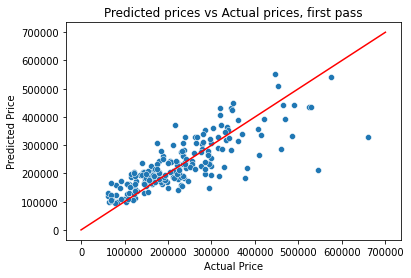

In [146]:
sns.scatterplot(x=actual_prices, y=predicted_prices)

X_plot = numpy.linspace(0, 7e5, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted prices vs Actual prices, first pass")
plt.show()

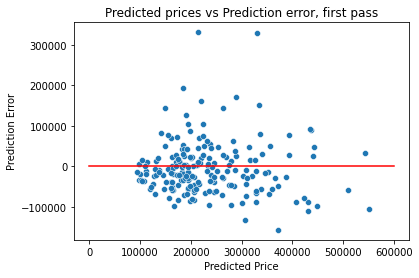

In [147]:
testing_prices_actual_predict['error'] = testing_prices_actual_predict['actual_price'] - testing_prices_actual_predict['predicted_price']

prediction_errors = testing_prices_actual_predict['error']

sns.scatterplot(x=predicted_prices, y=prediction_errors)

X_plot = numpy.linspace(0, 6e5, 10)
Y_plot = X_plot * 0
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")
plt.title("Predicted prices vs Prediction error, first pass")
plt.show()

A quick visual inspection shows that both plots have fewer points farther away from the red reference functions (that's good!).

## Reformulating the problem and model types

Up until now, we've been predicting the _price_ of the transactions, but there may be better variables to predict, which could lead to a more accurate model. For the next experiment, we'll try out predicting price per sq. ft., then multiplying the output by the square-footage, which will give us the price of the house.

In [148]:
housing_df['price_per_sqft'] = housing_df['price'] / housing_df['sq__ft']
housing_df = housing_df.drop(columns='price_bin', errors='ignore')

bin_count = 8
bins = numpy.histogram_bin_edges(housing_df['price_per_sqft'], bins=bin_count)
bin_array = numpy.digitize(housing_df['price_per_sqft'], bins)
housing_df['price_per_sqft_bin'] = bin_array
housing_df['price_per_sqft_bin'] = housing_df['price_per_sqft_bin'].where(housing_df['price_per_sqft_bin'] != (bin_count + 1), other=bin_count)

# Need to "cheat" the bins a little bit, since otherwise 8 bins with this dataset leaves a bin with only one item, which the train-test splitter doesn't like
housing_df['price_per_sqft_bin'] = housing_df['price_per_sqft_bin'].where(housing_df['price_per_sqft_bin'] != 8, other=6)

housing_df['price_per_sqft_bin'].value_counts()
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_per_sqft_bin'], random_state=42896)

numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

training_prices_per_sqft = training_df['price_per_sqft']
testing_prices_per_sqft = testing_df['price_per_sqft']
testing_sqft = testing_df['sq__ft']
testing_prices = testing_df['price']

columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_per_sqft', 'price_per_sqft_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

reg = SGDRegressor()
reg.fit(training_df, training_prices_per_sqft)

testing_prices_per_sqft_actual_predict = pd.DataFrame({'actual_price_per_sqft': testing_prices_per_sqft, 'predicted_price_per_sqft': reg.predict(testing_df)})
testing_prices_per_sqft_actual_predict.head()

,actual_price_per_sqft,predicted_price_per_sqft
732,172.119488,155.758224
401,148.381295,162.755966
522,120.420603,113.785148
367,149.253731,173.414219
701,186.607143,161.582663


The outputs look generally pretty good per a visual spot-check on the `head()`. Now, let's transform these values back to the price and calculate the error.

In [149]:
testing_prices_per_sqft_actual_predict['sq__ft'] = testing_sqft
testing_prices_per_sqft_actual_predict['actual_price'] = testing_prices
testing_prices_per_sqft_actual_predict['predicted_price'] = testing_prices_per_sqft_actual_predict['predicted_price_per_sqft'] * testing_prices_per_sqft_actual_predict['sq__ft']
testing_prices_per_sqft_actual_predict.head()

,actual_price_per_sqft,predicted_price_per_sqft,sq__ft,actual_price,predicted_price
732,172.119488,155.758224,1406,242000,218996.062519
401,148.381295,162.755966,1112,165000,180984.633830
522,120.420603,113.785148,3281,395100,373329.069809
367,149.253731,173.414219,804,120000,139425.032105
701,186.607143,161.582663,1120,209000,180972.582048


In [150]:
actual_prices = testing_prices_per_sqft_actual_predict['actual_price']
predicted_prices = testing_prices_per_sqft_actual_predict['predicted_price']
error_pass_3 = sqrt(mean_squared_error(actual_prices, predicted_prices))
error_pass_3

67828.80874349404

Once again, let's see how this differs from the first and second experiments.

In [151]:
percent_change = (error_pass_2 - error_pass_3) / error_pass_2 * 100
print("The model, now trained to predict price/sq-ft, improved by {:.2f}% against the second experiment".format(percent_change))

percent_change = (error_pass_1 - error_pass_3) / error_pass_1 * 100
print("It also improved by {:.2f}% against the first experiment".format(percent_change))

The model, now trained to predict price/sq-ft, improved by -2.34% against the second experiment
It also improved by 35.84% against the first experiment


Not bad! This error is similar to that of the experiment where the raw price was used as the output with outliers removed. To round out this experiment, let's take a look at the graphs.

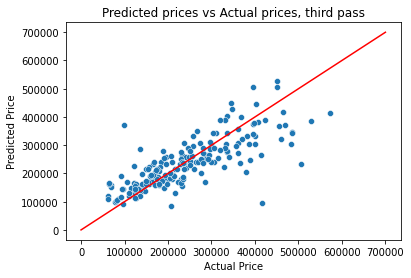

In [152]:
sns.scatterplot(x=actual_prices, y=predicted_prices)

X_plot = numpy.linspace(0, 7e5, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted prices vs Actual prices, third pass")
plt.show()

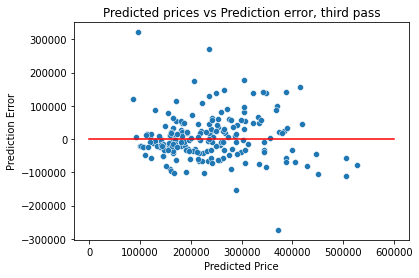

In [153]:
testing_prices_per_sqft_actual_predict['error'] = testing_prices_per_sqft_actual_predict['actual_price'] - testing_prices_per_sqft_actual_predict['predicted_price']

prediction_errors = testing_prices_per_sqft_actual_predict['error']

sns.scatterplot(x=predicted_prices, y=prediction_errors)

X_plot = numpy.linspace(0, 6e5, 10)
Y_plot = X_plot * 0
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")
plt.title("Predicted prices vs Prediction error, third pass")
plt.show()

## Feature engineering

For the next part of the project, we're going to play around with a few ways to potentially increase the accuracy of our model. We can engineer new features out our dataset to add more "juice" to train the model with.

### Sale day-of-year

The first one I'd like to try is day of the year. Conventional wisdom leads me to believe that folks are less likely to sell the house during the winter and more likely during the summer, which could cause demand fluctuations, and therefore price fluctuations throughout the year. This will entail writing a quick function to calculate the day of the year given a `datetime`, and adding it to the numerical column pipeline to be scaled, then retraining and repredicting.

In [154]:
housing_df = pd.read_csv(os.path.join(os.getcwd(), 'Sacramentorealestatetransactions.csv'))

def convert_to_date(x):
    return dateutil.parser.parse(x['sale_date'], ignoretz=True)

sale_dates = housing_df.apply(convert_to_date, axis='columns')
housing_df['sale_date'] = sale_dates

def convert_to_day_of_year(x):
    return x['sale_date'].timetuple().tm_yday

housing_df['day_of_year'] = housing_df.apply(convert_to_day_of_year, axis='columns')
housing_df['day_of_year'].value_counts()

140    268
137    264
141    177
142    158
136    118
Name: day_of_year, dtype: int64

Since there are only 5 values total, I'm thinking it would be better to one-hot encode this field rather than treat it as numeric and scale it. During the writing of this notebook, I had the opportunity to try out sklearn's `KBinsDiscretizer` and `OneHotEncoder` classes in a sandbox environment, so I'm going to build up the preprocessing pipeline with those classes instead of the `pandas` and `numpy` functions used earlier, and use it to preprocess this new feature set, after removing outliers first.

In [155]:
# Square-footage of 0
housing_df = housing_df[housing_df.sq__ft != 0]

# Property type of "Unkown"
housing_df = housing_df[housing_df.type != "Unkown"]

# Remove "very high" prices. Let's remove anything higher than the 99th price percentile
housing_df = housing_df[housing_df.price < housing_df['price'].quantile(.99)]

# Remove "very low" prices. Let's remove anything lower than the 1st price percentile
housing_df = housing_df[housing_df.price > housing_df['price'].quantile(.01)]

Now onto creating price bins...

In [156]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal')

price_bin_transformer = ColumnTransformer([
    ("kbins", discretizer, ['price'])
])

price_bins = price_bin_transformer.fit_transform(housing_df)
pd.DataFrame(price_bins).value_counts()

4.0    162
1.0    160
2.0    159
0.0    158
3.0    157
dtype: int64

In [157]:
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,day_of_year
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,2008-05-21,68212,38.478902,-121.431028,142
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,2008-05-21,68880,38.618305,-121.443839,142
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,2008-05-21,69307,38.616835,-121.439146,142
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,2008-05-21,81900,38.519470,-121.435768,142
5,5828 PEPPERMILL CT,SACRAMENTO,95841,CA,3,1,1122,Condo,2008-05-21,89921,38.662595,-121.327813,142


Let's get just the prices, for train-test splitting purposes.

In [158]:
housing_prices = housing_df['price']
housing_prices.head()

1    68212
2    68880
3    69307
4    81900
5    89921
Name: price, dtype: int64

We can now build up our preprocessing pipeline. By default, the ColumnTransformer will drop any column not transformed by it. That's good in our case, because if the transformer isn't touching it (like address and price), we don't need it.

In [159]:
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
categorical_columns = ['city', 'zip', 'type', 'day_of_year']

categorical_pipeline = make_pipeline(
    OneHotEncoder()
)

numeric_pipeline = make_pipeline(
    StandardScaler()
)

full_pipeline = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_columns),
    ("numeric", numeric_pipeline, numeric_columns)
])

Now, let's preprocess the master dataframe to get the master features matrix.

In [160]:
features_matrix = full_pipeline.fit_transform(housing_df)
features_matrix.shape

(796, 114)

We can train-test split the features matrix using the price bins from earlier.

In [161]:
training_df, testing_df, training_prices, testing_prices = train_test_split(features_matrix, housing_prices, test_size=0.25, stratify=price_bins, random_state=42896)

And finally, we'll train an `SGDRegressor` model and predict the prices for the testing dataset.

In [162]:
model = SGDRegressor()
model.fit(training_df, training_prices)
predicted_prices = model.predict(testing_df)
prices_compare = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': predicted_prices})
prices_compare.head()

,actual_price,predicted_price
280,300000,191902.867099
237,225000,217375.952964
682,190000,257034.377481
101,265000,180604.951138
458,241000,260760.608242


These appear to be somewhat reasonable, so how about an error calculation?

In [163]:
error_pass_4 = sqrt(mean_squared_error(testing_prices, predicted_prices))
error_pass_4

58740.93118911201

Not bad, but did it improve over the previous models? Let's find out.

In [164]:
percent_change = (error_pass_3 - error_pass_4) / error_pass_3 * 100
print("The model, now trained with the sale-day-of-year feature, improved by {:.2f}% against the third experiment".format(percent_change))

percent_change = (error_pass_2 - error_pass_4) / error_pass_2 * 100
print("It also improved by {:.2f}% against the second experiment".format(percent_change))

percent_change = (error_pass_1 - error_pass_4) / error_pass_1 * 100
print("It also improved by {:.2f}% against the first experiment".format(percent_change))

The model, now trained with the sale-day-of-year feature, improved by 13.40% against the third experiment
It also improved by 11.37% against the second experiment
It also improved by 44.44% against the first experiment


Seems like we're making incremental improvements to the model (generally speaking, as these errors will change on every run of the notebook).

### DBSCAN clustering

Using sklearn's built-in DBSCAN _(Density-Based Spatial Clustering of Applications with Noise)_ class, we can create discrete clusters by latitude and longitude. One of the parameters to `DBSCAN` is `epsilon`, which controls the maximum distance between two points to be considered within the same cluster. After a little experimentation, I settled on X miles as the epsilon value, which generates Y clusters for our dataset. Since latitude and longitude are, of course, a spherical coordinate system, we'll need to use the _haversine_ metric, which calculates distances on a sphere, and convert the epsilon to radians, using 3958.76133381 mi/rad.

In [165]:
mi_per_radian = 3958.76133381 # constant used for calculating epsilon
epsilon = 1 / mi_per_radian   # epsilon = 1 mile; points need to be within 1 mile of each other to form a cluster
min_samples = 5               # at least 5 samples are needed to form a cluster, otherwise they are classified as noise (-1)

coords = housing_df[['latitude', 'longitude']]

clusters = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(numpy.radians(coords))
cluster_labels = clusters.labels_
housing_df['cluster'] = cluster_labels
housing_df

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,day_of_year,cluster
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,2008-05-21,68212,38.478902,-121.431028,142,0
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,2008-05-21,68880,38.618305,-121.443839,142,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,2008-05-21,69307,38.616835,-121.439146,142,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,2008-05-21,81900,38.519470,-121.435768,142,0
5,5828 PEPPERMILL CT,SACRAMENTO,95841,CA,3,1,1122,Condo,2008-05-21,89921,38.662595,-121.327813,142,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,2008-05-15,232425,38.457679,-121.359620,136,0
981,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,Residential,2008-05-15,234000,38.499893,-121.458890,136,0
982,7933 DAFFODIL WAY,CITRUS HEIGHTS,95610,CA,3,2,1216,Residential,2008-05-15,235000,38.708824,-121.256803,136,12
983,8304 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Residential,2008-05-15,235301,38.417000,-121.397424,136,0


Great! Now that it's part of the dataframe, we'll run it through our preprocessing pipeline, and one-hot encode this new feature, since the cluster's numerical value is of little importance. Furthermore, since the cluster is a more important symbol of location, we'll drop the latitude and longitude out of the feature matrix to see if we get any improvement.

In [166]:
categorical_columns = ['city', 'zip', 'type', 'cluster']
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']

full_pipeline = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_columns),
    ("numeric", numeric_pipeline, numeric_columns)
])

features_matrix = full_pipeline.fit_transform(housing_df)
features_matrix

<796x125 sparse matrix of type '<class 'numpy.float64'>'
	with 7164 stored elements in Compressed Sparse Row format>

And again, train-test splitting, model training, and predicting...

In [167]:
training_df, testing_df, training_prices, testing_prices = train_test_split(features_matrix, housing_prices, test_size=0.25, stratify=price_bins, random_state=42896)

model = SGDRegressor()
model.fit(training_df, training_prices)
predicted_prices = model.predict(testing_df)
prices_compare = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': predicted_prices})
prices_compare.head()

,actual_price,predicted_price
280,300000,181778.440894
237,225000,195760.699595
682,190000,284577.134358
101,265000,183915.366834
458,241000,257381.186590


These values look _ok_ via visual spot-check, so let's calculate the error and compare it with the previous experiments.

In [168]:
error_pass_5 = sqrt(mean_squared_error(testing_prices, predicted_prices))
error_pass_5

59252.212900556144

In [169]:
percent_change = (error_pass_4 - error_pass_5) / error_pass_4 * 100
print("The model, now trained with the geo-clusters feature, improved by {:.2f}% against the fourth experiment".format(percent_change))

percent_change = (error_pass_3 - error_pass_5) / error_pass_3 * 100
print("It also improved by {:.2f}% against the third experiment".format(percent_change))

percent_change = (error_pass_2 - error_pass_5) / error_pass_2 * 100
print("It also improved by {:.2f}% against the second experiment".format(percent_change))

percent_change = (error_pass_1 - error_pass_5) / error_pass_1 * 100
print("It also improved by {:.2f}% against the first experiment".format(percent_change))

The model, now trained with the geo-clusters feature, improved by -0.87% against the fourth experiment
It also improved by 12.64% against the third experiment
It also improved by 10.60% against the second experiment
It also improved by 43.96% against the first experiment


### K-means clustering

Using DBSCAN clustering didn't considerably improve the accuracy of the model, but I still think clustering could prove useful in improving this model, as that tracks with my understanding of how real estate prices work. Houses within the same area should market for similar prices, right? K-means clustering is another, and much more widely known, clustering algorithm. Although it works better for flat geometry than the spherical plane latitude/longitude coordinates are projected on, all of our data are within a single US city and it's immediate suburbs, so the effect of the curvature of the Earth should be negligible. Let's give it a shot.

In [170]:
housing_df = pd.read_csv(os.path.join(os.getcwd(), 'Sacramentorealestatetransactions.csv'))

# Square-footage of 0
housing_df = housing_df[housing_df.sq__ft != 0]

# Property type of "Unkown"
housing_df = housing_df[housing_df.type != "Unkown"]

# Remove "very high" prices. Let's remove anything higher than the 99th price percentile
housing_df = housing_df[housing_df.price < housing_df['price'].quantile(.99)]

# Remove "very low" prices. Let's remove anything lower than the 1st price percentile
housing_df = housing_df[housing_df.price > housing_df['price'].quantile(.01)]

coords = housing_df[['latitude', 'longitude']]

clusters = KMeans(n_clusters=12).fit(coords).labels_
housing_df['cluster'] = clusters
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,cluster
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,11
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,11
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,10
5,5828 PEPPERMILL CT,SACRAMENTO,95841,CA,3,1,1122,Condo,Wed May 21 00:00:00 EDT 2008,89921,38.662595,-121.327813,3


In [171]:
categorical_columns = ['city', 'zip', 'type', 'cluster']
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']

full_pipeline = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_columns),
    ("numeric", numeric_pipeline, numeric_columns)
])

features_matrix = full_pipeline.fit_transform(housing_df)
features_matrix

<796x121 sparse matrix of type '<class 'numpy.float64'>'
	with 7164 stored elements in Compressed Sparse Row format>

In [172]:
training_df, testing_df, training_prices, testing_prices = train_test_split(features_matrix, housing_prices, test_size=0.25, stratify=price_bins, random_state=42896)

model = SGDRegressor()
model.fit(training_df, training_prices)
predicted_prices = model.predict(testing_df)
prices_compare = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': predicted_prices})
prices_compare.head()

,actual_price,predicted_price
280,300000,185769.644332
237,225000,220775.131228
682,190000,245728.347358
101,265000,188094.974763
458,241000,258349.738341


In [173]:
error_pass_6 = sqrt(mean_squared_error(testing_prices, predicted_prices))
error_pass_6

57723.31755394336

In [174]:
percent_change = (error_pass_5 - error_pass_6) / error_pass_5 * 100
print("The model, now trained with the (K-means) geo-clusters feature, improved by {:.2f}% against the fifth experiment".format(percent_change))

percent_change = (error_pass_4 - error_pass_6) / error_pass_4 * 100
print("It also improved by {:.2f}% against the fourth experiment".format(percent_change))

percent_change = (error_pass_3 - error_pass_6) / error_pass_3 * 100
print("It also improved by {:.2f}% against the third experiment".format(percent_change))

percent_change = (error_pass_2 - error_pass_6) / error_pass_2 * 100
print("It also improved by {:.2f}% against the second experiment".format(percent_change))

percent_change = (error_pass_1 - error_pass_6) / error_pass_1 * 100
print("It also improved by {:.2f}% against the first experiment".format(percent_change))

The model, now trained with the (K-means) geo-clusters feature, improved by 2.58% against the fifth experiment
It also improved by 1.73% against the fourth experiment
It also improved by 14.90% against the third experiment
It also improved by 12.91% against the second experiment
It also improved by 45.40% against the first experiment


Unfortunately, it seems that we're now only making incremental increases to the accuracy of our models, if not worse. However, we've only chipped away the tip of the iceberg in terms of what features we can design using the columns in the data. Even though there are other ways to perhaps improve the model with feature engineering, such as tuning the hyperparameters on the clustering algorithms, for the sake of brevity, let's explore another way to potentially improve our model...

## Adding More Data

Instead of looking _inward_ on the columns in our dataset engineer features from, let's branch _outward_ to some other datasets that we can join to our existing set of columns, that we'll then encode, scale, and make features out of for training the regression model. Let's start by importing some data from the US Census Bureau. I was able to find a dataset with counts of housing units per ZIP code from the 2010 census (officially titled _H1: HOUSING UNITS_) after perusing the Census Bureau's data website (https://data.census.gov), so let's take a look at that.

In [233]:
census_housing_estimates = pd.read_csv(os.path.join(os.getcwd(), 'external_data', 'DECENNIALSF12010.H1_data_with_overlays_2022-01-25T180920.csv'))
census_housing_estimates.head()

,GEO_ID,H001001,NAME
0,id,Total,Geographic Area Name
1,8600000US89010,279,ZCTA5 89010
2,8600000US89019,1623,ZCTA5 89019
3,8600000US89060,4988,ZCTA5 89060
4,8600000US89061,2567,ZCTA5 89061


The total number of houses per ZIP code could be representative of population density, which in turn could be representative of house values. Let's drop the `GEO_ID`, since it's irrelevant to what we're interested in.

In [234]:
census_housing_units_by_zip = census_housing_estimates[['NAME', 'H001001']]
census_housing_units_by_zip.head()

,NAME,H001001
0,Geographic Area Name,Total
1,ZCTA5 89010,279
2,ZCTA5 89019,1623
3,ZCTA5 89060,4988
4,ZCTA5 89061,2567


We'll do a little more massaging to get this into a friendlier format to `join` to our existing dataset.

In [235]:
# Drop the first row, as it's column headers and not an actual data point
census_housing_units_by_zip = census_housing_units_by_zip[1:]

# We'll need just the 5-digit ZIP, so parse it out of the NAME
census_housing_units_by_zip['zip'] = census_housing_units_by_zip.apply(lambda x: x['NAME'][-5:], axis='columns')

# Drop the NAME field
census_housing_units_by_zip = census_housing_units_by_zip.drop(columns=['NAME'])

# Rename the weird column name to something human readable
census_housing_units_by_zip = census_housing_units_by_zip.rename(columns={'H001001': 'zip_housing_units'})

# Change their datatypes to ints
census_housing_units_by_zip['zip'] = census_housing_units_by_zip['zip'].astype('int64')
census_housing_units_by_zip['zip_housing_units'] = census_housing_units_by_zip['zip_housing_units'].astype('int64')
census_housing_units_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1769 entries, 1 to 1769
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   zip_housing_units  1769 non-null   int64
 1   zip                1769 non-null   int64
dtypes: int64(2)
memory usage: 27.8 KB


In [236]:
census_housing_units_by_zip.head()

,zip_housing_units,zip
1,279,89010
2,1623,89019
3,4988,89060
4,2567,89061
5,718,89439


Now this is looking good! Let's join it to the "master" dataframe.

In [237]:
housing_df = pd.read_csv(os.path.join(os.getcwd(), 'Sacramentorealestatetransactions.csv'))
housing_df = housing_df.merge(census_housing_units_by_zip, on='zip', how='inner')

# Square-footage of 0
housing_df = housing_df[housing_df.sq__ft != 0]

# Property type of "Unkown"
housing_df = housing_df[housing_df.type != "Unkown"]

# Remove "very high" prices. Let's remove anything higher than the 99th price percentile
housing_df = housing_df[housing_df.price < housing_df['price'].quantile(.99)]

# Remove "very low" prices. Let's remove anything lower than the 1st price percentile
housing_df = housing_df[housing_df.price > housing_df['price'].quantile(.01)]

housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,zip_housing_units
1,645 MORRISON AVE,SACRAMENTO,95838,CA,3,2,909,Residential,Wed May 21 00:00:00 EDT 2008,100309,38.637663,-121.451520,11587
2,3820 NATOMA WAY,SACRAMENTO,95838,CA,4,2,1656,Residential,Wed May 21 00:00:00 EDT 2008,166357,38.636748,-121.422159,11587
3,211 MCDANIEL CIR,SACRAMENTO,95838,CA,3,2,1110,Residential,Tue May 20 00:00:00 EDT 2008,123750,38.636565,-121.460383,11587
4,604 MORRISON AVE,SACRAMENTO,95838,CA,2,1,952,Residential,Tue May 20 00:00:00 EDT 2008,134000,38.637678,-121.452476,11587
5,648 SANTA ANA AVE,SACRAMENTO,95838,CA,3,2,1211,Residential,Tue May 20 00:00:00 EDT 2008,135000,38.658478,-121.450409,11587


Now it's a feature! Let's re-run our preprocessing pipeline and scale this new variable.

In [238]:
categorical_columns = ['city', 'zip', 'type']
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude', 'zip_housing_units']

full_pipeline = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_columns),
    ("numeric", numeric_pipeline, numeric_columns)
])

features_matrix = full_pipeline.fit_transform(housing_df)
features_matrix

<796x110 sparse matrix of type '<class 'numpy.float64'>'
	with 7164 stored elements in Compressed Sparse Row format>

Of course, the usual experimental setup...

In [239]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal')

price_bin_transformer = ColumnTransformer([
    ("kbins", discretizer, ['price'])
])

price_bins = price_bin_transformer.fit_transform(housing_df)

housing_prices = housing_df['price']
housing_prices.head()

training_df, testing_df, training_prices, testing_prices = train_test_split(features_matrix, housing_prices, test_size=0.25, stratify=price_bins, random_state=42896)

model = SGDRegressor()
model.fit(training_df, training_prices)
predicted_prices = model.predict(testing_df)
prices_compare = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': predicted_prices})
prices_compare.head()

,actual_price,predicted_price
454,445000,258664.960309
234,185074,185224.669538
459,213750,302871.883519
210,249862,181360.698301
504,238000,210839.526989


How'd we do?

In [240]:
error_pass_7 = sqrt(mean_squared_error(testing_prices, predicted_prices))
error_pass_7

67098.07977599917

Our error is still hovering around $70k, which isn't particularly better or worse than our previous experiments. Let's see what other datasets we can pull in to enhance our model. I was able to find another dataset from the Census Bureau that tracks, per ZIP code, the total population within owner-occupied housing units (separated by with a mortgage and owned free-and-clear) and renter-occupied housing units. Reflecting on Milwaukee's areas where property values are higher, i.e the East side, Shorewood, Lakefront, I'd expect to see higher property values where there's a higher ratio of renters, as many of the properties are multi-unit buildings owned by large (and _wealthy_) investment firms. Let's see if we can massage this data and engineer this ratio as a feature and add it to the real estate transaction dataset.

In [241]:
occupied_housing_df = pd.read_csv(os.path.join(os.getcwd(), 'external_data', 'DECENNIALSF12010.H11_data_with_overlays_2022-01-25T182408.csv'))
occupied_housing_df = occupied_housing_df.rename(columns={'H011001': 'total_population', 'H011002': 'owner_occupied_mortgage', 'H011003': 'owner_occupied_clear', 'H011004': 'renter_occupied'})
occupied_housing_df = occupied_housing_df.drop(columns=['GEO_ID'])
occupied_housing_df = occupied_housing_df[1:]
occupied_housing_df['zip'] = occupied_housing_df.apply(lambda x: x['NAME'][-5:], axis='columns')

def get_renter_to_population_ratio(x):
    try:
        val = int(x['renter_occupied']) / int(x['total_population'])
    except ZeroDivisionError:
        val = 0
    return val

occupied_housing_df['renters_to_total'] = occupied_housing_df.apply(get_renter_to_population_ratio, axis='columns')
new_features = occupied_housing_df[['zip', 'renters_to_total']]
new_features['zip'] = new_features['zip'].astype('int64')
new_features.head()

C:\Users\Jack\AppData\Local\Temp/ipykernel_32624/781743160.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_features['zip'] = new_features['zip'].astype('int64')


,zip,renters_to_total
1,89010,0.337349
2,89019,0.335329
3,89060,0.266329
4,89061,0.236481
5,89439,0.216655


That's more like it! Let's join to our master dataframe, set up, and run the experiment.

In [242]:
housing_df = housing_df.merge(new_features, on='zip', how='inner')
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,zip_housing_units,renters_to_total
0,645 MORRISON AVE,SACRAMENTO,95838,CA,3,2,909,Residential,Wed May 21 00:00:00 EDT 2008,100309,38.637663,-121.451520,11587,0.495839
1,3820 NATOMA WAY,SACRAMENTO,95838,CA,4,2,1656,Residential,Wed May 21 00:00:00 EDT 2008,166357,38.636748,-121.422159,11587,0.495839
2,211 MCDANIEL CIR,SACRAMENTO,95838,CA,3,2,1110,Residential,Tue May 20 00:00:00 EDT 2008,123750,38.636565,-121.460383,11587,0.495839
3,604 MORRISON AVE,SACRAMENTO,95838,CA,2,1,952,Residential,Tue May 20 00:00:00 EDT 2008,134000,38.637678,-121.452476,11587,0.495839
4,648 SANTA ANA AVE,SACRAMENTO,95838,CA,3,2,1211,Residential,Tue May 20 00:00:00 EDT 2008,135000,38.658478,-121.450409,11587,0.495839


In [243]:
categorical_columns = ['city', 'zip', 'type']
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude', 'zip_housing_units', 'renters_to_total']

full_pipeline = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_columns),
    ("numeric", numeric_pipeline, numeric_columns)
])

features_matrix = full_pipeline.fit_transform(housing_df)
features_matrix

<796x111 sparse matrix of type '<class 'numpy.float64'>'
	with 7960 stored elements in Compressed Sparse Row format>

In [246]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal')

price_bin_transformer = ColumnTransformer([
    ("kbins", discretizer, ['price'])
])

price_bins = price_bin_transformer.fit_transform(housing_df)

housing_prices = housing_df['price']

training_df, testing_df, training_prices, testing_prices = train_test_split(features_matrix, housing_prices, test_size=0.25, stratify=price_bins, random_state=42896)

model = SGDRegressor()
model.fit(training_df, training_prices)
predicted_prices = model.predict(testing_df)
prices_compare = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': predicted_prices})
prices_compare.head()

,actual_price,predicted_price
435,445000,258608.106444
227,185074,184836.714384
440,213750,301686.122147
204,249862,178667.747043
480,238000,211148.430056


In [247]:
error_pass_8 = sqrt(mean_squared_error(testing_prices, predicted_prices))
error_pass_8

67415.01865636426